GPU acceleration in place powered by TensorFlow (GPU)


/var/folders/dc/g0mch30j1x5c1gspqpsmhf900000gn/T/ipykernel_33008/3557399535.py:51: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNet(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
2024-06-10 20:01:05.386056: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-06-10 20:01:05.386147: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-10 20:01:05.386158: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-10 20:01:05.386438: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-10 20:01:05.386482: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:27

Epoch 1/50


2024-06-10 20:01:08.486951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


391/391 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - accuracy: 0.1708 - loss: 2.2384 - val_accuracy: 0.2228 - val_loss: 2.1602 - learning_rate: 0.0010
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 97ms/step - accuracy: 0.2071 - loss: 2.1736 - val_accuracy: 0.2226 - val_loss: 2.1420 - learning_rate: 0.0010
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 103ms/step - accuracy: 0.2119 - loss: 2.1665 - val_accuracy: 0.2241 - val_loss: 2.1360 - learning_rate: 0.0010
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - accuracy: 0.2114 - loss: 2.1611 - val_accuracy: 0.2274 - val_loss: 2.1333 - learning_rate: 0.0010
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 108ms/step - accuracy: 0.2157 - loss: 2.1533 - val_accuracy: 0.2290 - val_loss: 2.1318 - learning_rate: 0.0010
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 101ms/step - accuracy: 0.2185 - loss: 2.1549 - val_accuracy: 0.2255 - val_loss: 2.1315 - learning_rate: 0.0010
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.2131 - loss: 

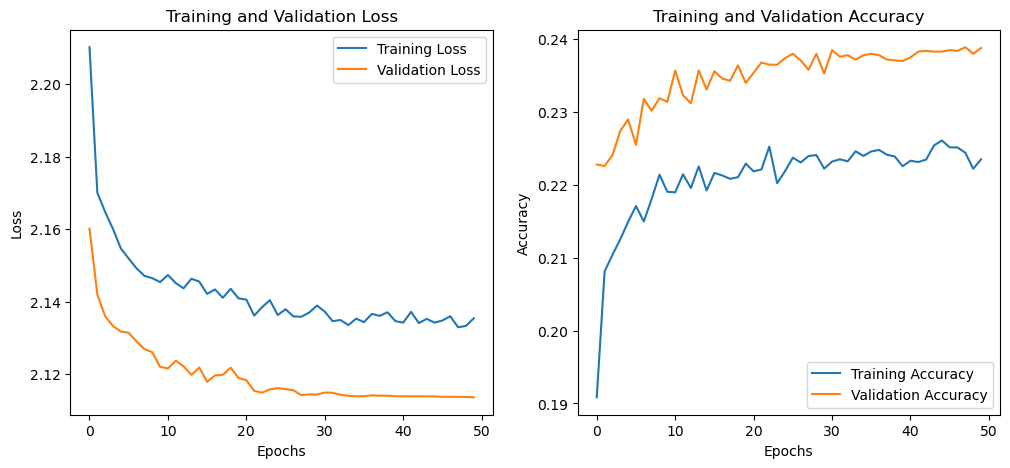

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step
Detailed Statistics:
Number of Epochs: 50
Optimizer: adam
Learning Rate: Adjusted dynamically with ReduceLROnPlateau
Loss Function: Sparse Categorical Crossentropy
Metrics: Accuracy
Final Test Accuracy: 23.88%
Final Test Loss: 2.11
Precision: 0.25
Recall: 0.24
F1 Score: 0.22
Total Training Time: 29 minutes, 25.52 seconds
Average Time per Epoch: 35.31 seconds


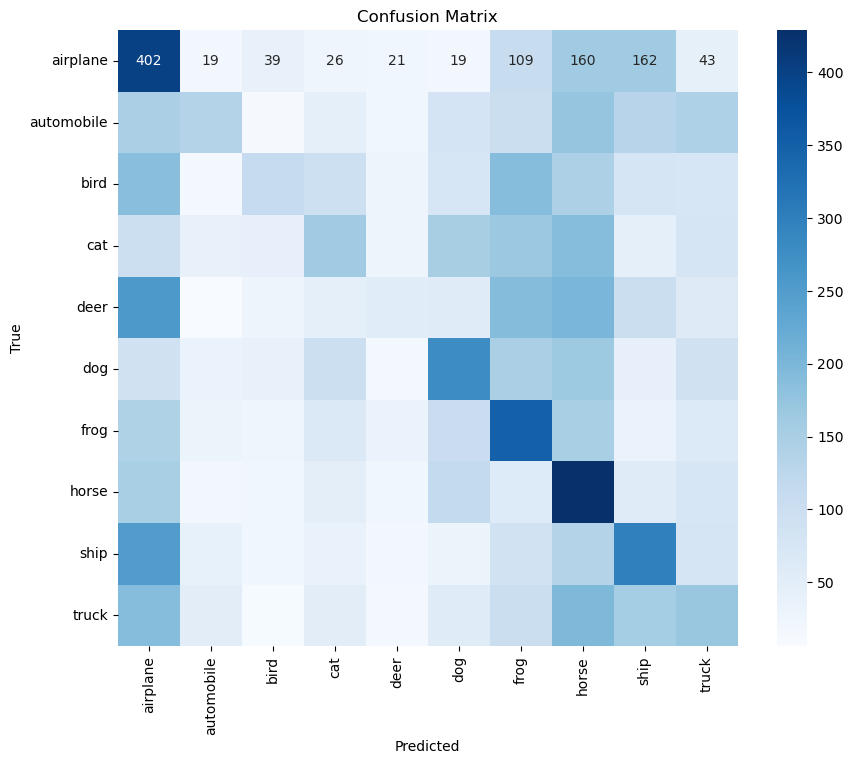

In [3]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import time  # To measure training time

# Function to calculate evaluation metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
    return accuracy, precision, recall, f1

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Check available devices
physical_devices = tf.config.list_physical_devices()
if "GPU" in [device.device_type for device in physical_devices]:
    device_info = "GPU acceleration in place powered by TensorFlow (GPU)"
else:
    device_info = "Using CPU... Best of luck..."
print(device_info)

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

# Define the MobileNet model
base_model = tf.keras.applications.MobileNet(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
base_model.trainable = False  # Freeze the pre-trained weights

# Adding classification layers on top
flatten_layer = layers.Flatten()
dense_layer = layers.Dense(256, activation='relu')
dropout_layer = layers.Dropout(0.5)
output_layer = layers.Dense(10, activation='softmax')

# Construct the model
inputs = Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = flatten_layer(x)
x = dense_layer(x)
x = dropout_layer(x)
outputs = output_layer(x)
model = models.Model(inputs, outputs)

# Compile the model
optimizer = 'adam'
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Set up early stopping and learning rate reduction on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Start time for training
start_time = time.time()

# Train the model with augmented data
history = model.fit(datagen.flow(x_train, y_train, batch_size=128),
                    epochs=50,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

# End time for training
end_time = time.time()
total_training_time = end_time - start_time
average_epoch_time = total_training_time / len(history.history['loss'])

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

# Plot the training curves
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

# Make predictions
y_pred = np.argmax(model.predict(x_test), axis=-1)

# Calculate evaluation metrics
accuracy, precision, recall, f1 = calculate_metrics(y_test, y_pred)

# Print detailed statistics
print("Detailed Statistics:")
print(f"Number of Epochs: {len(history.history['loss'])}")
print(f"Optimizer: {optimizer}")
print(f"Learning Rate: Adjusted dynamically with ReduceLROnPlateau")
print(f"Loss Function: Sparse Categorical Crossentropy")
print(f"Metrics: Accuracy")

print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Final Test Loss: {test_loss:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Total Training Time: {total_training_time // 60:.0f} minutes, {total_training_time % 60:.2f} seconds")
print(f"Average Time per Epoch: {average_epoch_time:.2f} seconds")

# Plot confusion matrix
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(y_test, y_pred, classes)
